<a href="https://colab.research.google.com/github/buntys2010/Game-of-Deep-Learning-Hackathon/blob/master/Updated_GOD_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read Data

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 47.7MB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':'1zRzgwnzMs52MN674v6TFDOMrKi1jg6dN'}) 
downloaded.GetContentFile('train.zip')  

In [0]:
!unzip '../content/train.zip'

Archive:  ../content/train.zip
   creating: images/
  inflating: images/2870091.jpg      
   creating: __MACOSX/
   creating: __MACOSX/images/
  inflating: __MACOSX/images/._2870091.jpg  
  inflating: images/2860282.jpg      
  inflating: __MACOSX/images/._2860282.jpg  
  inflating: images/2894465.jpg      
  inflating: __MACOSX/images/._2894465.jpg  
  inflating: images/2784253.jpg      
  inflating: __MACOSX/images/._2784253.jpg  
  inflating: images/2853890.jpg      
  inflating: __MACOSX/images/._2853890.jpg  
  inflating: images/2898539.jpg      
  inflating: __MACOSX/images/._2898539.jpg  
  inflating: images/644577.jpg       
  inflating: __MACOSX/images/._644577.jpg  
  inflating: images/2856056.jpg      
  inflating: __MACOSX/images/._2856056.jpg  
  inflating: images/2792357.jpg      
  inflating: __MACOSX/images/._2792357.jpg  
  inflating: images/2904710.jpg      
  inflating: __MACOSX/images/._2904710.jpg  
  inflating: images/2748659.jpg      
  inflating: __MACOSX/images

In [0]:
train = pd.read_csv('../content/train.csv')

In [0]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [0]:
test = pd.read_csv('../content/test_ApKoW4T.csv')

In [0]:
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


## Model

Approch :

1. Using transfer learning using resnet50 pre-trained model to train the images
2. Since we have less number of training example , we need to more focus on Data Aurgmentation 
3. Using FASTAI for the first time , adjust the learning rate to improve the accuracy

In [0]:
from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt
import torchvision.models as t_models

In [0]:
path = Path('../content/images/')

In [0]:
train_df = ImageList.from_df(train,'../content/images')
test_df = ImageList.from_df(test, '../content/images')

Using Data aurgmentation as below

*  do_flip =  False (Tried True didnt had much effect)
*  flip_vert = False (We can use this when the pictures are taken from a hight)
* let's rotate the pictures a bit randomly max_rotate=10 (it's already default ).
*  zoom in a higher bit max_zoom (as we are dealing with ships picture that are small compared to overall image).
* max_warp is set to zero as it seems to perform better in this case.



In [0]:
np.random.seed(42)

data = ImageDataBunch.from_df('../content/images', train, 
ds_tfms=get_transforms(do_flip=False,flip_vert=False,max_rotate=10,max_zoom=1.22,max_lighting=0.3,p_affine=0.3,p_lighting=0.75),valid_pct=0.20, size=300, bs=32 ,resize_method=ResizeMethod.SQUISH ).normalize(imagenet_stats)

In [0]:
print(data.classes)
len(data.classes),data.c

[1, 2, 3, 4, 5]


(5, 5)

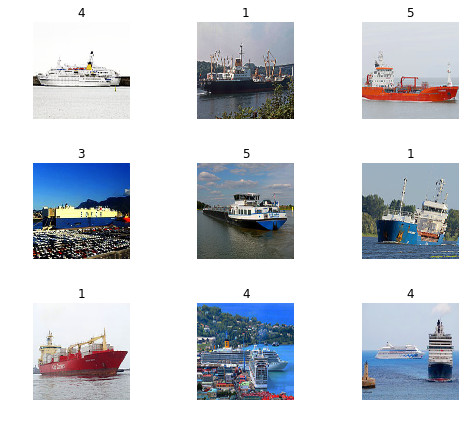

In [0]:
data.show_batch(rows=3,figsize=(7,6))

In [0]:
data.add_test(test_df)

**We can use different models and different size of the image and take an average of those models.**



**I couldnt do that due to lack of time.**

In [0]:
learn = create_cnn(data,models.resnet50,metrics=[error_rate,accuracy],callback_fns=ShowGraph)
#learn = create_cnn(data,t_models.inception_v3,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 29594885.01it/s]


In [0]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________

In [0]:
learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03


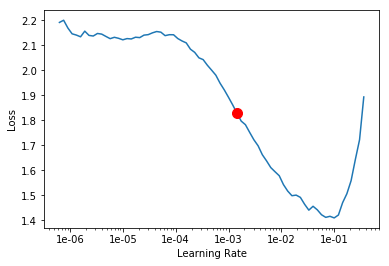

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.736688,0.493966,0.173600,0.826400,01:15
1,0.545074,0.372080,0.142400,0.857600,01:16
2,0.410022,0.299836,0.108800,0.891200,01:19
3,0.312517,0.265178,0.103200,0.896800,01:20
4,0.291220,0.239464,0.085600,0.914400,01:22
5,0.217811,0.261815,0.092000,0.908000,01:22
6,0.187350,0.189403,0.080800,0.919200,01:22
7,0.160691,0.181380,0.068800,0.931200,01:21
8,0.141282,0.162303,0.069600,0.930400,01:22
9,0.121748,0.163595,0.062400,0.937600,01:22


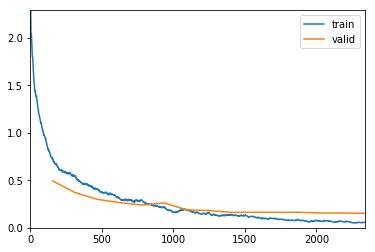

In [0]:
#lets start with steepset slope point. adding wd (weight decay) not to overfit as we are running 15 epochs 
lr = 3e-03
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(15, slice(lr), wd=0.2)

In [0]:
learn.save('stg-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


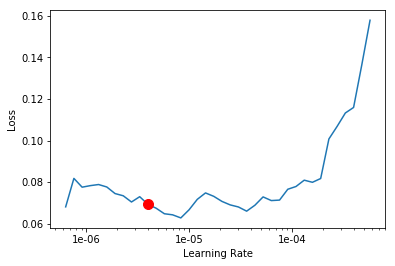

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.067327,0.121369,0.042400,0.957600,01:51
1,0.046003,0.117505,0.048000,0.952000,01:52
2,0.037281,0.125839,0.043200,0.956800,01:51
3,0.028352,0.117543,0.037600,0.962400,01:52
4,0.027761,0.147602,0.044800,0.955200,01:51
5,0.023606,0.133075,0.036800,0.963200,01:52
6,0.010651,0.129387,0.041600,0.958400,01:52
7,0.008570,0.123519,0.035200,0.964800,01:52
8,0.006386,0.129394,0.038400,0.961600,01:52
9,0.006376,0.126687,0.034400,0.965600,01:52


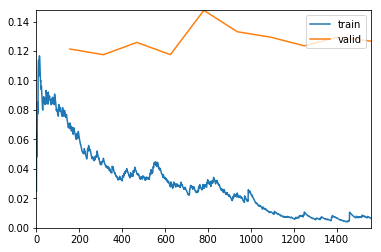

In [0]:
learn.unfreeze()
learn.fit_one_cycle(15,max_lr=slice(1e-05,lr/8),wd=0.15)

In [0]:
learn.unfreeze()
learn.freeze_to(-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.006331,0.137212,0.035200,0.964800,01:52
1,0.009786,0.186945,0.044000,0.956000,01:51
2,0.017173,0.145999,0.039200,0.960800,01:52
3,0.010753,0.150702,0.040000,0.960000,01:52
4,0.009961,0.142119,0.039200,0.960800,01:51
5,0.003402,0.145402,0.038400,0.961600,01:52


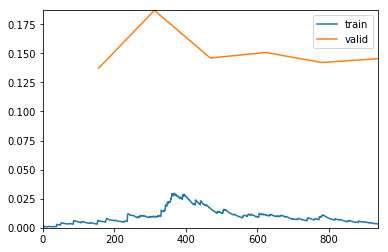

In [0]:
learn.fit_one_cycle(6, slice(1e-05, lr/10),wd=0.1)

In [0]:
## freezing initial all layers except last 2 layers
learn.freeze_to(-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.004361,0.121930,0.034400,0.965600,01:37
1,0.008655,0.174754,0.041600,0.958400,01:37
2,0.002606,0.151567,0.036000,0.964000,01:37
3,0.005720,0.145990,0.035200,0.964800,01:37
4,0.003958,0.144719,0.036000,0.964000,01:38
5,0.004795,0.150381,0.037600,0.962400,01:37


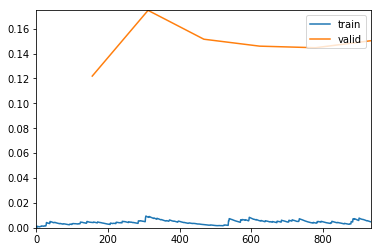

In [0]:
learn.fit_one_cycle(6, slice(5e-06, lr/20),wd=0.1)

In [0]:
learn.freeze_to(-1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.003261,0.142095,0.036000,0.964000,01:21
1,0.002855,0.151837,0.035200,0.964800,01:22
2,0.002245,0.142171,0.033600,0.966400,01:22
3,0.002480,0.145093,0.035200,0.964800,01:22
4,0.002119,0.148813,0.036800,0.963200,01:22
5,0.001291,0.148919,0.033600,0.966400,01:22
6,0.006279,0.147497,0.036000,0.964000,01:22
7,0.001244,0.147594,0.034400,0.965600,01:22
8,0.001490,0.148895,0.033600,0.966400,01:22
9,0.001661,0.145322,0.034400,0.965600,01:22


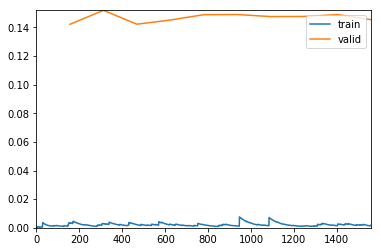

In [0]:
## training even more
learn.fit_one_cycle(10, slice(1e-07, lr/30),wd=0.05)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.001365,0.144874,0.034400,0.965600,01:14
1,0.002167,0.149216,0.035200,0.964800,01:17
2,0.001635,0.155641,0.034400,0.965600,01:20
3,0.002823,0.147496,0.033600,0.966400,01:22
4,0.001153,0.151366,0.036000,0.964000,01:22
5,0.000706,0.154041,0.035200,0.964800,01:22


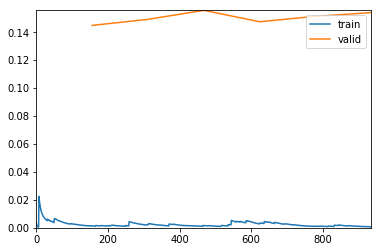

In [0]:
learn.fit_one_cycle(6, slice(1e-07, lr/100))


## Interpretation

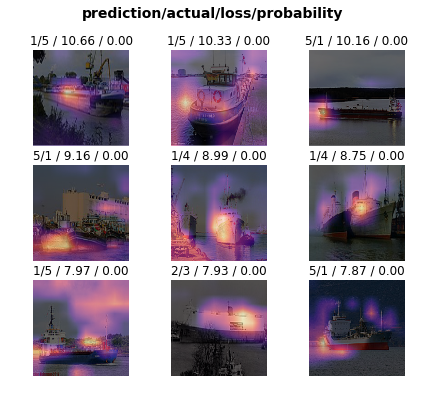

In [0]:
#lets see the most mis-classified images (on validation set)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,6))

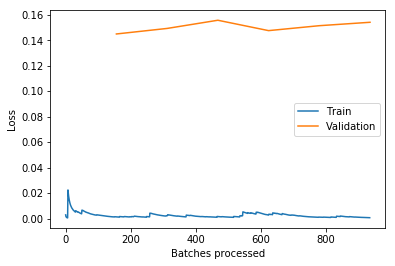

In [0]:
learn.recorder.plot_losses()

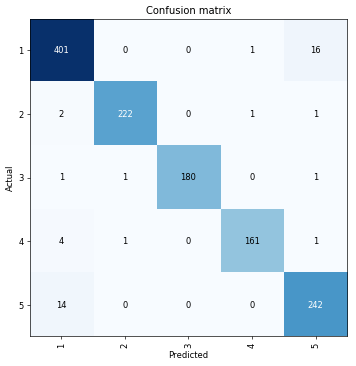

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60) ## on validation set

In [0]:
interp.most_confused(min_val=4) ## on validation set

[(1, 5, 16), (5, 1, 14), (4, 1, 4)]

It seems like our model is finding difficult to distinguish between ship 1 (cargo) and 5 (tanker)


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
from sklearn import metrics
print(metrics.classification_report(interp.y_true.numpy(), interp.pred_class.numpy() ))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       418
           1       0.99      0.98      0.99       226
           2       1.00      0.98      0.99       183
           3       0.99      0.96      0.98       167
           4       0.93      0.95      0.94       256

    accuracy                           0.96      1250
   macro avg       0.97      0.97      0.97      1250
weighted avg       0.97      0.96      0.96      1250



Predicted using TTA as it could improve accuracy further (Test time augmentation). Applies Test Time Augmentation to our learner on the dataset.

Here We take the average of our regular predictions (with a weight beta) with the average of predictions obtained through augmented versions of the training set (with a weight 1-beta). Details can be found here

In [0]:
##learn.TTA improves score further. lets see for the validation set
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

(0.968, 0.968)

In [0]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]

labelled_preds = np.array(labelled_preds)

In [0]:
sub = pd.read_csv('../content/sample_submission_ns2btKE.csv')

In [0]:
sub.head()

In [0]:
sub['category'] = labelled_preds

In [0]:
sub.to_csv('FASIAI_Sub1.csv',index=False)

Things could have tried more :

1. I have seen many top rankers solution they used different size of image and different models and then taken an average

2. Should do more pre-processing of images in class 1 and 5 which model can identify correctly